In [1]:
%%writefile utils.py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
import base64
import io
from IPython.display import HTML

SEED = 42 # Added SEED

def plot_learning_curve(scores, epsilon_history, filename):
    fig, ax1 = plt.subplots()
    ax1.plot(scores, color='blue')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Score', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(epsilon_history, color='red')
    ax2.set_ylabel('Epsilon', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title('Learning Curve')
    plt.savefig(filename)
    plt.close()

def preprocess_state(state):
    return np.array(state, dtype=np.float32)

def save_model(model, filename="dqn_model.h5"):
    model.save(filename)

def load_model(filename="dqn_model.h5"):
    from tensorflow.keras.models import load_model
    return load_model(filename)

def display_video(frames):
    from IPython.display import HTML
    import base64
    import io
    from matplotlib import animation

    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        return (patch,)

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
    return HTML(anim.to_jshtml())

def display_table(current_state, action, next_state, reward, done):
    from IPython.display import display, HTML
    import pandas as pd

    data = {'Current State': [current_state],
            'Action': [action],
            'Next State': [next_state],
            'Reward': [reward],
            'Done': [done]}
    df = pd.DataFrame(data)
    display(HTML(df.to_html()))

def update_target_network(q_network, target_q_network):
    """
    Updates the weights of the target Q-network with the weights of the Q-network.
    """
    target_q_network.set_weights(q_network.get_weights())

def create_video(filename, env, q_network, num_episodes=1):
    """
    Creates a video of the agent playing the game.

    Args:
        filename (str): The name of the output video file.
        env (gym.Env): The environment.
        q_network (tf.keras.Model): The Q-Network.
        num_episodes (int): The number of episodes to record.
    """
    with imageio.get_writer(filename, fps=60) as video:
        for i in range(num_episodes):
            state = env.reset()[0]
            done = False
            while not done:
                frame = env.render()
                video.append_data(frame)
                state_qn = tf.expand_dims(state, axis=0)
                q_values = q_network(state_qn)
                action = tf.argmax(q_values, axis=1).numpy()[0]
                state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

def embed_mp4(filename):
    """
    Embeds an mp4 file in the notebook.

    Args:
        filename (str): The name of the mp4 file.

    Returns:
        HTML: The HTML code to embed the video.
    """
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
    </video>'''.format(b64.decode())
    return HTML(tag)

Writing utils.py


In [2]:
!pip install pyvirtualdisplay

In [3]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import importlib
import utils
importlib.reload(utils)  # Reloads the updated utils.py


from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [4]:
# Set up a virtual display to render the Lunar Lander environment.
Display(visible=0, size=(840, 480)).start();

# Set the random seed for TensorFlow
tf.random.set_seed(utils.SEED)

In [5]:
!pip install swig==4.*
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379416 sha256=2a0431fb6997014a3baafa91329989eb003572a9c90da0240342dd4796fb8c6e
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [6]:
import gymnasium as gym

env = gym.make('LunarLander-v3', render_mode="rgb_array")  # Use render_mode for rendering
obs, info = env.reset()
print("Observation shape:", obs.shape)
print("Action space:", env.action_space)


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


Observation shape: (8,)
Action space: Discrete(4)


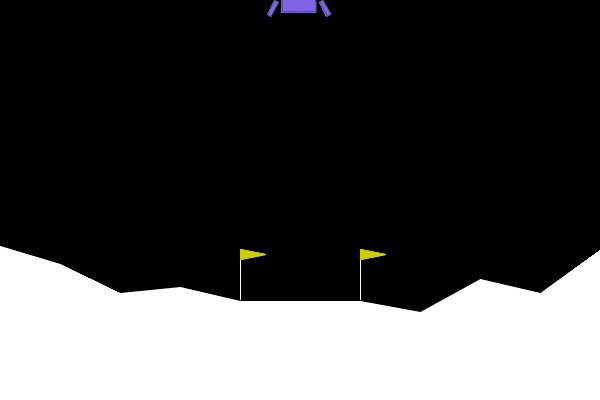

In [7]:
from PIL import Image

env = gym.make('LunarLander-v3', render_mode="rgb_array")
obs, info = env.reset()

frame = env.render()
Image.fromarray(frame)

In [8]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [9]:
# Reset the environment and get the initial state.
current_state = env.reset()

In [10]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, terminated, truncated, _ = env.step(action) # Unpack 5 values

# Display table with values.
utils.display_table(current_state, action, next_state, reward, terminated or truncated) # Use terminated or truncated for done

# Replace the `current_state` with the state after the action is taken
current_state = next_state

,Current State,Action,Next State,Reward,Done
0,"([-0.00789814, 1.40132, -0.8000162, -0.42670166, 0.009158806, 0.18121558, 0.0, 0.0], {})",0,"[-0.015796948, 1.3911443, -0.7989356, -0.45234144, 0.018113265, 0.17910685, 0.0, 0.0]",-1.025042,False


In [11]:

# Define the learning rate
ALPHA = 0.001 # You can adjust this value

# Create the Q-Network
q_network = Sequential([
    Input(shape=(state_size[0],)),           # Input layer
    Dense(64, activation='relu'),            # First hidden layer
    Dense(64, activation='relu'),            # Second hidden layer
    Dense(num_actions, activation='linear')  # Output layer
])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=(state_size[0],)),           # Input layer
    Dense(64, activation='relu'),            # First hidden layer
    Dense(64, activation='relu'),            # Second hidden layer
    Dense(num_actions, activation='linear')  # Output layer
])

# Set the optimizer
optimizer = Adam(learning_rate=ALPHA)

In [12]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [13]:

def select_action(state, epsilon, q_network, num_actions):
    """
    Selects an action using an epsilon-greedy policy.

    Args:
        state (np.ndarray): The current state of the environment.
        epsilon (float): The probability of choosing a random action.
        q_network (tf.keras.Model): The Q-Network.
        num_actions (int): The number of possible actions.

    Returns:
        int: The selected action.
    """
    # Reshape state to match the input shape of the Q-network
    state = tf.expand_dims(state, axis=0)

    # Generate a random number
    random_number = np.random.rand()

    # Choose action based on epsilon-greedy policy
    if random_number <= epsilon:
        # Explore: choose a random action
        action = np.random.randint(num_actions)
    else:
        # Exploit: choose the action with the highest Q-value
        q_values = q_network(state)
        action = tf.argmax(q_values, axis=1).numpy()[0]

    return action

In [14]:
# UNQ_C2
# GRADED FUNCTION: compute_loss

def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calculates the loss.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor) the Mean-Squared Error between y_targets and Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s', a') from target network
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Compute y targets: y = R + (1 - done) * gamma * max_qsa
    y_targets = rewards + (1 - done_vals) * gamma * max_qsa

    # Get the q_values for the actions taken
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Compute the loss (Mean Squared Error)
    loss = MSE(y_targets, q_values)

    return loss


In [15]:
# @tf.function # Remove tf.function decorator
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.

    """

    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Clip the gradients by global norm
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, clip_norm=1.0) # Add gradient clipping

    # Check for None gradients and shape mismatches as a workaround
    valid_gradients = []
    valid_variables = []
    for grad, var in zip(clipped_gradients, q_network.trainable_variables):
        if grad is not None and tf.shape(grad).numpy().size > 0 and tf.shape(grad).numpy().tolist() == tf.shape(var).numpy().tolist():
            valid_gradients.append(grad)
            valid_variables.append(var)
        else:
            # Optional: Print a warning if a gradient is skipped
            # print(f"Skipping gradient update for variable {var.name} due to invalid gradient shape.")
            pass


    # Update the weights of the q_network.
    # Only apply gradients for which valid gradients were computed
    if valid_gradients: # Check if there are any valid gradients to apply
        optimizer.apply_gradients(zip(valid_gradients, valid_variables)) # Apply only valid gradients

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [16]:
# UNQ_C3
# GRADED FUNCTION

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Args:
            buffer_size: maximum size of buffer
            batch_size: size of training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)


    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]), dtype=tf.float32)
        actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.int64)
        rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
        next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]), dtype=tf.float32)
        done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]), dtype=tf.float32)

        return (states, actions, rewards, next_states, done_vals)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [24]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Define hyperparameters
MEMORY_SIZE = 100000     # capacity of the replay buffer
BATCH_SIZE = 64         # size of the mini-batch
NUM_STEPS_FOR_UPDATE = 4  # number of steps to wait before updating the target network
GAMMA = 0.99            # discount factor

# Create a memory buffer D with capacity N
import random # Import random module
memory_buffer = ReplayBuffer(MEMORY_SIZE, BATCH_SIZE) # Use ReplayBuffer class

# Define the experience namedtuple globally (no longer needed as it's defined in ReplayBuffer)
# experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state = env.reset()[0] # Access the observation
    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        # state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        # q_values = q_network(state_qn)
        action = select_action(state, epsilon, q_network, num_actions) # Use the defined select_action function

        # Take action A and receive reward R and the next state S'
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store experience tuple (S,A,R,S', done) in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.add(state, action, reward, next_state, done) # Use the add method of the replay buffer

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        # update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        # Sample random mini-batch of experience tuples (S,A,R,S') from D
        if len(memory_buffer) > BATCH_SIZE and t % NUM_STEPS_FOR_UPDATE == 0: # Check if buffer is large enough and update condition is met
             experiences = memory_buffer.sample() # Use the sample method of the replay buffer

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
             agent_learn(experiences, GAMMA)


        state = next_state
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    # epsilon = utils.get_new_eps(epsilon) # Use a proper epsilon decay schedule
    epsilon = max(0.01, epsilon * 0.995) # Simple epsilon decay

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -109.52
Episode 200 | Total point average of the last 100 episodes: -32.15
Episode 300 | Total point average of the last 100 episodes: 22.69
Episode 400 | Total point average of the last 100 episodes: 152.76
Episode 500 | Total point average of the last 100 episodes: 188.97
Episode 507 | Total point average of the last 100 episodes: 200.54

Environment solved in 507 episodes!

Total Runtime: 4257.88 s (70.96 min)


In [18]:
# Plot the total point history along with the moving average
utils.plot_learning_curve(total_point_history, [], 'learning_curve.png') # Use plot_learning_curve

In [19]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [20]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [21]:
import os
if not os.path.exists("./videos"):
    os.makedirs("./videos")

In [22]:
filename = "./videos/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)